In [1]:
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [2]:
!kaggle competitions download -c career-con-2019

 53% 9.00M/17.1M [00:00<00:00, 20.8MB/s]
100% 17.1M/17.1M [00:00<00:00, 38.5MB/s]
  0% 0.00/64.1k [00:00<?, ?B/s]
100% 64.1k/64.1k [00:00<00:00, 66.2MB/s]
  0% 0.00/51.1k [00:00<?, ?B/s]
100% 51.1k/51.1k [00:00<00:00, 43.9MB/s]
 52% 9.00M/17.2M [00:00<00:00, 24.4MB/s]
100% 17.2M/17.2M [00:00<00:00, 38.7MB/s]


In [3]:
!unzip X_test.csv.zip
!unzip X_train.csv.zip

Archive:  X_test.csv.zip
  inflating: X_test.csv              
Archive:  X_train.csv.zip
  inflating: X_train.csv             


In [0]:
import numpy as np
import pandas as pd
from seaborn import countplot, barplot
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix

#from bayes_opt import BayesianOptimization
import lightgbm as lgb
import xgboost as xgb
# import catboost as cb

In [0]:
x_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")
X_test = pd.read_csv("X_test.csv")

In [0]:
x_train.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


In [0]:
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [0]:
def feature_extraction(raw_frame):
    frame = pd.DataFrame()
    raw_frame['orientation'] = raw_frame['orientation_X'] + raw_frame['orientation_Y'] + raw_frame['orientation_Z']+ raw_frame['orientation_W']
    raw_frame['orientation_xyz'] = (raw_frame['orientation_X']**2 + raw_frame['orientation_Y']**2 + raw_frame['orientation_Z']**2)**0.5
    raw_frame['angular_velocity'] = (raw_frame['angular_velocity_X']**2 + raw_frame['angular_velocity_Y']**2 + raw_frame['angular_velocity_Z']**2)**0.5
    raw_frame['linear_acceleration'] = (raw_frame['linear_acceleration_X']**2 + raw_frame['linear_acceleration_Y']**2 + raw_frame['linear_acceleration_Z']**2)**0.5
    raw_frame['velocity_to_acceleration'] =  raw_frame['linear_acceleration'] / raw_frame['angular_velocity']
    
#     x, y, z, w = raw_frame['orientation_X'].tolist(), raw_frame['orientation_Y'].tolist(), raw_frame['orientation_Z'].tolist(), raw_frame['orientation_W'].tolist()
#     nx, ny, nz = [], [], []
#     for i in range(len(x)):
#         xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
#         nx.append(xx)
#         ny.append(yy)
#         nz.append(zz)
    
#     raw_frame['euler_x'] = nx
#     raw_frame['euler_y'] = ny
#     raw_frame['euler_z'] = nz
    
#     raw_frame['total_angle'] = np.sqrt(np.square(raw_frame['euler_x']) + np.square(raw_frame['euler_y']) + np.square(raw_frame['euler_z']))
    
    # print(raw_frame.columns[3])
    for col in raw_frame.columns[3:]:
        frame[col + '_mean'] = raw_frame.groupby(['series_id'])[col].mean()
        frame[col + '_median'] = raw_frame.groupby(['series_id'])[col].median()
        frame[col + '_std'] = raw_frame.groupby(['series_id'])[col].std()
        frame[col + '_max'] = raw_frame.groupby(['series_id'])[col].max()
        frame[col + '_min'] = raw_frame.groupby(['series_id'])[col].min()
        frame[col + '_max_to_min'] = frame[col + '_max'] / frame[col + '_min']
        frame[col + '_mean_abs_change'] = raw_frame.groupby('series_id')[col].apply(lambda x: np.mean(np.abs(np.diff(x))))
        frame[col + '_abs_max'] = raw_frame.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
        frame[col + '_abs_min'] = raw_frame.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))
        # frame[col + '_abs_avg'] = (raw_frame[col + '_abs_min'] + raw_frame[col + '_abs_max'])/2
    return frame

In [0]:
trainm = feature_extraction(x_train)
testm = feature_extraction(X_test)

In [0]:
label=y_train
label=label["surface"]

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(label)
label=label_encoder.transform(label)

In [0]:
for i in range(100):
    print(label[i],label_encoder.inverse_transform(label)[i])

In [9]:
Y_train = label
X_train = trainm
test = testm

scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
from sklearn.linear_model import LogisticRegression
>>> from sklearn.naive_bayes import GaussianNB
>>> from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

In [0]:
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

In [12]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=59)
sub_preds_rf = np.zeros((test.shape[0], 9))
new = np.zeros((X_train.shape[0], 9))
oof_preds_rf = np.zeros((X_train.shape[0]))
score = 0
for i, (train_index, test_index) in enumerate(folds.split(X_train, Y_train)):
    print('-'*20, i, '-'*20)
#     gb = RandomForestClassifier(n_estimators = 50, n_jobs = -1)
#     eclf1 = gb.fit(X_train.iloc[train_index], Y_train[train_index])
    # clf.fit(X_train.iloc[train_index], Y_train[train_index])
    clf_rf_3 = RandomForestClassifier(n_estimators = 500, n_jobs = -1)      
    rfe = RFECV(estimator=clf_rf_3)
    eclf1 = rfe.fit(X_train.iloc[train_index], Y_train[train_index])
    oof_preds_rf[test_index] = eclf1.predict(X_train.iloc[test_index])
    sub_preds_rf += eclf1.predict_proba(test) / folds.n_splits
    new += eclf1.predict_proba(X_train) / folds.n_splits
    score += eclf1.score(X_train.iloc[test_index], Y_train[test_index])
    print('score ', eclf1.score(X_train.iloc[test_index], Y_train[test_index]))

# print('Optimal number of features :', eclf1.n_features)

-------------------- 0 --------------------


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


score  0.8981723237597912
-------------------- 1 --------------------


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


score  0.8771241830065359
-------------------- 2 --------------------


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


score  0.8871391076115486
-------------------- 3 --------------------


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


score  0.8789473684210526
-------------------- 4 --------------------


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


score  0.9009247027741083


In [0]:
new

array([[0.  , 0.  , 0.98, ..., 0.  , 0.  , 0.02],
       [0.04, 0.94, 0.  , ..., 0.  , 0.02, 0.  ],
       [0.  , 0.82, 0.04, ..., 0.  , 0.  , 0.12],
       ...,
       [0.  , 0.04, 0.82, ..., 0.  , 0.1 , 0.04],
       [0.  , 0.  , 0.  , ..., 0.  , 0.96, 0.04],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ]])

In [0]:
pp = eclf1.predict_proba(X_train) / folds.n_splits

In [0]:
import itertools
def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

In [0]:
for i in range(3810):
    if Y_train[i]!=oof_preds_rf[i]:
        inx.append(i)

In [0]:
val = eclf1.predict_proba(X_train)

In [0]:
c = 0
for i in range(len(inx)):
    c += np.abs(val[inx[i]][Y_train[inx[i]]]-val[inx[i]][int(oof_preds_rf[inx[i]])])
c /= len(inx)
c

0.22484558773677787

In [0]:
Y_train[inx[0]],oof_preds_rf[inx[0]]

(1, 8.0)

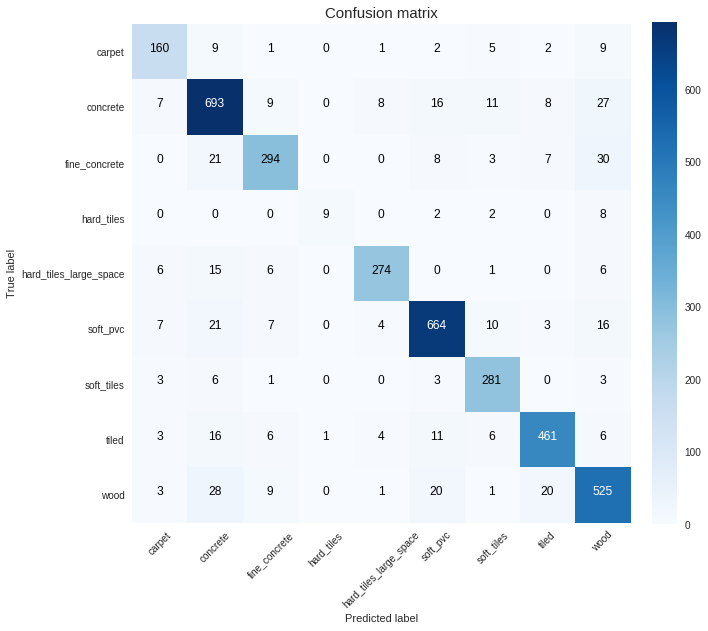

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix
plot_confusion_matrix(Y_train, oof_preds_rf, label_encoder.classes_)

In [0]:
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=59)
sub_preds_rf = np.zeros((test.shape[0], 9))
oof_preds_rf = np.zeros((X_train.shape[0]))
score = 0

for i, (train_index, test_index) in enumerate(folds.split(X_train, Y_train)):
    print('-'*20, i, '-'*20)
    
    clf =  RandomForestClassifier(n_estimators = 50,n_jobs = -1)
    clf.fit(X_train.iloc[train_index], Y_train[train_index])
    oof_preds_rf[test_index] = clf.predict(X_train.iloc[test_index])
    sub_preds_rf += clf.predict_proba(test) / folds.n_splits
    score += clf.score(X_train.iloc[test_index], Y_train[test_index])
    print('score ', clf.score(X_train.iloc[test_index], Y_train[test_index]))
#     importances = clf.feature_importances_
#     indices = np.argsort(importances)
#     features = X_train.columns
#     hm = 30
#     plt.figure(figsize=(7, 10))
#     plt.title('Feature Importances')
#     plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
#     plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
#     plt.xlabel('Relative Importance')
#     plt.show()

print('Avg Accuracy', score / folds.n_splits)

-------------------- 0 --------------------
score  0.8994778067885117
-------------------- 1 --------------------
score  0.9019607843137255
-------------------- 2 --------------------
score  0.9146981627296588
-------------------- 3 --------------------
score  0.8789473684210526
-------------------- 4 --------------------
score  0.9233817701453104
Avg Accuracy 0.9036931784796518


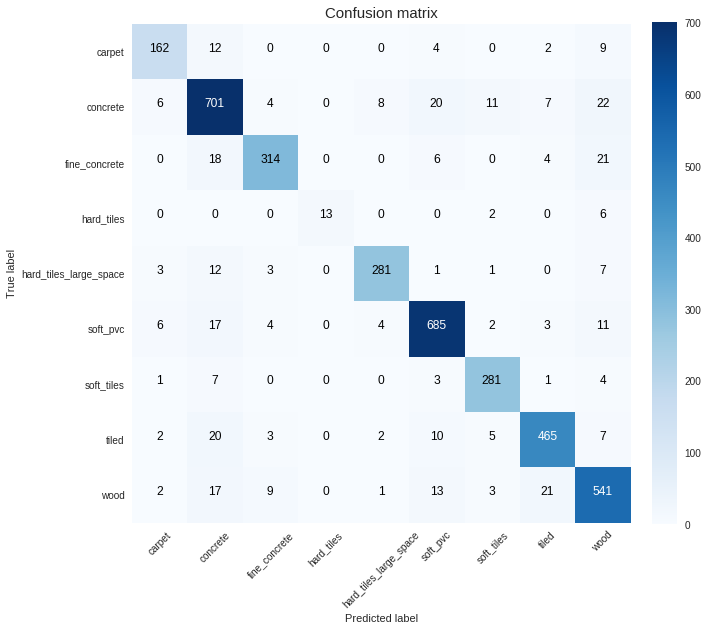

In [0]:
from sklearn.metrics import accuracy_score, confusion_matrix
plot_confusion_matrix(Y_train, oof_preds_rf, label_encoder.classes_)

In [13]:
xy = label_encoder.inverse_transform(sub_preds_rf.argmax(axis=1))
xy


array(['hard_tiles_large_space', 'carpet', 'tiled', ...,
       'hard_tiles_large_space', 'concrete', 'wood'], dtype=object)

In [14]:
submission1 = pd.DataFrame({
        "series_id": testm.index,
        "surface": xy,
        
    })
submission1.surface.value_counts()

concrete                  893
wood                      678
soft_pvc                  659
soft_tiles                468
tiled                     347
hard_tiles_large_space    313
fine_concrete             307
carpet                    150
hard_tiles                  1
Name: surface, dtype: int64

In [0]:
submission1.to_csv('submission.csv', index=False)

In [16]:
!kaggle competitions submit -c career-con-2019 -f submission.csv -m "ett_fet1"

100% 53.8k/53.8k [00:02<00:00, 18.8kB/s]
Successfully submitted to CareerCon 2019 - Help Navigate Robots 